In [1]:
using CMBLensing, CMBLensingInferenceTestProblem, CUDA, LaTeXStrings, MCMCDiagnosticTools, Plots, ProgressMeter, Random, Zygote
ENV["LINES"] = 10;

# Loading the problem

This loads the problem up (couple of minutes the first call, then seconds for subsequent calls). The parameters you see below are customizable. 

* Turn up `Nside` to get a bigger map and make the problem harder/slower. 
* You can switch to `storage = Array` if you don't have a GPU, but its much slower. 
* `T = Float32` should be fine and is faster, but you can try `T = Float64` if your sampler demands higher numerical precision.

In [2]:
prob = load_cmb_lensing_problem(
    storage = CuArray,
    T = Float32,
    Nside = 64,
);

The CMB lensing problem has a posterior which looks like:

$$ \log \mathcal{P} (\underbrace{f^\circ, \phi^\circ, \theta}_{\Omega}\,|\,d) $$

The variables $f^\circ$ and $\phi^\circ$ are maps of the unlensed CMB and of the lensing potential (after an internal change-of-variables which helps decorrelate/Gaussianize the posterior). The $\theta$ are the parameters of interest, which here is the tensor-to-scalar ratio, $r$, and the overall lensing amplitude, $A_\phi$ (actually, their $\log$, so that they are transformed to $(-\infty,\infty)$). The code uses $\Omega$ to represent the entire parameter vector together, which we will be sampling.

The code here gives you a "black-box" for the following ingredients, which are needed for sampling:

## Starting point

The starting point is the maximum a posteriori (MAP) estimate. You don't _have_ to use this, but starting here as opposed to a zero or random starting point helps _alot_ in the HMC sampler:

In [3]:
prob.Ωstart

12290-element Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}, LambertMap{CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}:
  -4.798799514770508
 -10.132034301757812
 -13.010290145874023
   ⋮
  -1.6094379124341003
   0.0

Note: the returned object is a special kind of `AbstractVector` which tracks all the different components. It acts just like a normal Julia `Vector` and you can add/multiply/dot, etc..., but it won't work through code that explicitly expects `Vector` or which is looping over indicies like `prob.Ωstart[1]`, so some work may be needed to make sure your sampling code is sufficiently general and uses high-level operations (not indexing). 

## Log posterior and gradient

To get the log-posterior, call the object on a parameter vector:

In [4]:
prob(prob.Ωstart)

98678.26f0

The gradient is computed Zygote:

In [ ]:
Zygote.gradient(prob, prob.Ωstart)[1]

12290-element Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}, LambertMap{CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}:
  0.0028597484342753887
 -0.00012366101145744324
  0.002917067613452673
  ⋮
 -2.494336634501815
 36.76360608637333

## Mass matrix

In [6]:
prob.Λmass

6338×6338 Diagonal{ComplexF64, Field-(f°,ϕ°,θ)-Tuple{LambertEBFourier{CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}, LambertFourier{CuArray{ComplexF32, 2, CUDA.Mem.DeviceBuffer}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}}:
 0.0+0.0im          ⋅              ⋅      …      ⋅          ⋅          ⋅    
     ⋅      2.64101+0.0im          ⋅             ⋅          ⋅          ⋅    
     ⋅              ⋅      4.12679+0.0im         ⋅          ⋅          ⋅    
    ⋮                                     ⋱     ⋮                  
     ⋅              ⋅              ⋅             ⋅      1.0+0.0im      ⋅    
     ⋅              ⋅              ⋅             ⋅          ⋅      1.0+0.0im

The mass matrix approximates the Hessian of the log posterior. Even for this tiny problem, it would be 12290x12290 elements, which is very large, so its never explicitly stored as a matrix. But you can generate a random momentum from it with (equivalent to $\Lambda^{1/2} z$ for a random normal vector $z$):

In [7]:
simulate(prob.Λmass)

6338-element Field-(f°,ϕ°,θ)-Tuple{LambertEBFourier{CuArray{ComplexF32, 3, CUDA.Mem.DeviceBuffer}}, LambertFourier{CuArray{ComplexF32, 2, CUDA.Mem.DeviceBuffer}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}:
                -0.0 + 0.0im
   128.8284912109375 - 21.768360137939453im
 -135.91468811035156 + 132.64234924316406im
                     ⋮
 -1.7028551832614671 + 0.0im
 -0.7031860933333528 + 0.0im

and multiply it by a parameter vector:

In [8]:
prob.Λmass * prob.Ωstart

6338-element Field-(f°,ϕ°,θ)-Tuple{LambertEBFourier{CuArray{ComplexF32, 3, CUDA.Mem.DeviceBuffer}}, LambertFourier{CuArray{ComplexF32, 2, CUDA.Mem.DeviceBuffer}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}:
                 0.0 - 0.0im
  -42.12908172607422 + 530.7584838867188im
    3278.51220703125 - 1076.11962890625im
                     ⋮
 -1.6094379124341003 + 0.0im
                 0.0 + 0.0im

which should be the ingredients needed to do sampling. 

# Canonical HMC solution

This is doing 500 HMC samples with 25 leap-frog steps per sample with fixed step size of 0.05.

In [9]:
Ω = prob.Ωstart
chain = []
rng = Xoshiro(1)
@showprogress for i=1:500
    Ω, = state = hmc_step(rng, prob, Ω, prob.Λmass; symp_kwargs=[(N=25, ϵ=0.05)], progress=false, always_accept=(i<10))
    push!(chain, state)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:10:34


## Plotting up HMC results

Trace plot of chain:

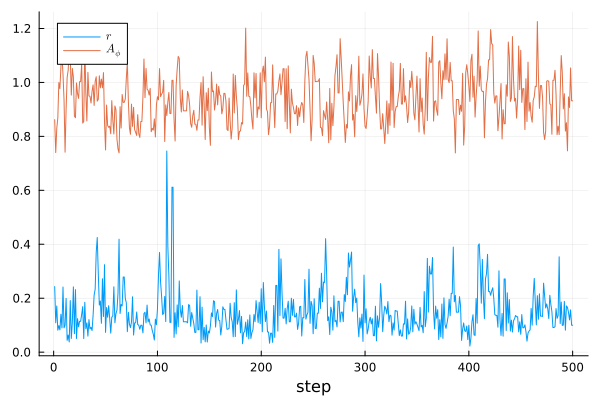

In [17]:
plot([exp(Ω.θ.r) for (Ω,) in chain], label=L"r", xlabel="step")
plot!([exp(Ω.θ.Aϕ) for (Ω,) in chain], label=L"A_\phi")

Parameter posteriors:

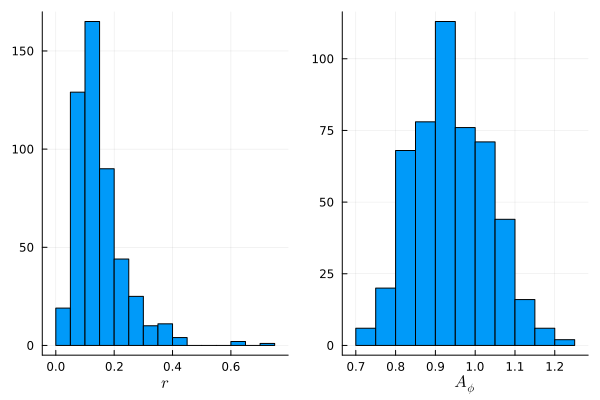

In [18]:
plot(
    histogram([exp(Ω.θ.r) for (Ω,) in chain], xlabel=L"r", label=nothing),
    histogram([exp(Ω.θ.Aϕ) for (Ω,) in chain], xlabel=L"A_\phi", label=nothing)
)

Effective sample size and correlation length (after burnin of 100 steps):

In [19]:
ess = ess_rhat(reshape([Ω.θ.r for (Ω,) in chain[100:end]], (:,1,1)))[1][1]
corr_length = length(chain[100:end]) / ess
(;ess, corr_length)

(ess = 96.01918939136654, corr_length = 4.176248545127329)

Hamiltonian error trace:

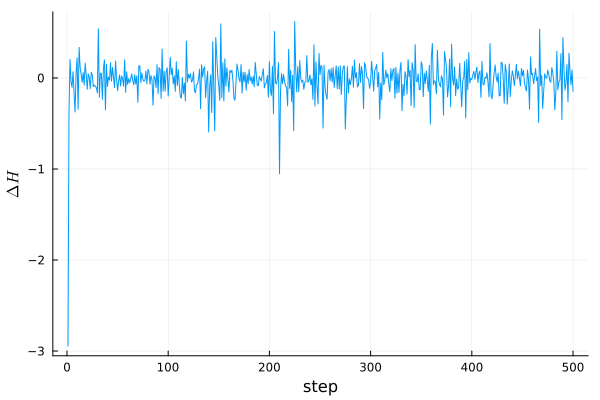

In [20]:
plot(getindex.(chain, 2), label=nothing, xlabel="step", ylabel=L"\Delta H")

Power spectra of maps. The starting point will have Wiener-filter-like power suppression, and the final sample should have power comparable to the truth.

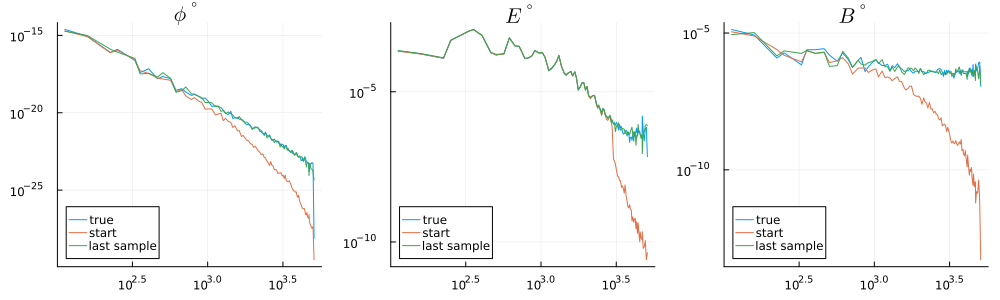

GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27


In [21]:
ps = map([(:ϕ°,:I,L"L",L"\phi^\circ"), (:f°,:E,"L\ell",L"E^\circ"), (:f°,:B,L"\ell",L"B^\circ")]) do (k1, k2, xlabel, title)
    plot(get_Cℓ(prob.Ωtrue[k1][k2]); label="true", xlabel, title)
    plot!(get_Cℓ(prob.Ωstart[k1][k2]); label="start", xlabel, title)
    plot!(get_Cℓ(chain[end][1][k1][k2]); label="last sample", xlabel, title)
end
plot(ps..., layout=(1,3), xscale=:log10, yscale=:log10, size=(1000,300), legend=:bottomleft)

An animation of the $\kappa^\circ(=\nabla^2\phi^\circ/2)$ samples:

In [36]:
samps = [∇²*Ω.ϕ°/2 for (Ω,) in chain[100:end]]
anim = @animate for i in 1:length(samps)
    motionblur = [0.5, 1, 0.5]
    frame = sum(circshift(samps, i)[1:length(motionblur)] .* motionblur) / sum(motionblur)
    plot(1 * frame, clims=(-0.5, 0.5), c=:thermal, title="κ samples")
end;

In [37]:
mp4(anim, "kappa_samples.mp4", fps = 25)

[ Info: Saved animation to /n/home12/marius/work/CMBLensingInferenceTestCase/kappa_samples.mp4


Plots.AnimatedGif("/n/home12/marius/work/CMBLensingInferenceTestCase/kappa_samples.mp4")